In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [42]:
features = ['total_hits2','total_ring_PEs2','recoDWallR2','recoDWallZ2','lambda_max_2']
target = ['trueKE']
data_all = pd.read_csv('numu_energy_studies.csv', usecols=features+target)

In [43]:
# clean the data and perform sanity checks
data_all.dropna(inplace=True)
data_all.head(5)

trueKE  total_hits2  total_ring_PEs2  recoDWallR2  recoDWallZ2  \
0  236.327     0.023325          0.00000     0.003389     0.458415   
1  186.765     0.010075          0.00000     0.003389     0.458415   
2  448.481     0.080400          0.13070     0.035389     0.753969   
3  586.647     0.011950          0.00000     0.042498     0.083664   
4  963.822     0.142300          0.26265     0.616305     0.164307   

   lambda_max_2  
0      0.650854  
1      0.405903  
2      0.537975  
3      0.830098  
4      0.092105

In [44]:
target_data = data_all[target].to_numpy()
print(np.max(target_data), np.min(target_data))
print(np.max(data_all['total_hits2'].to_numpy()), np.min(data_all['total_hits2'].to_numpy()))

4855.33 1.83213
1.08133 0.00025


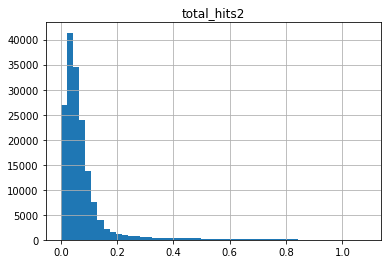

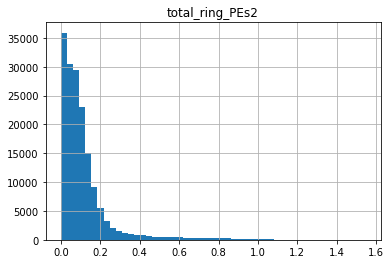

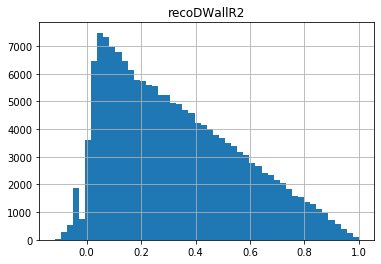

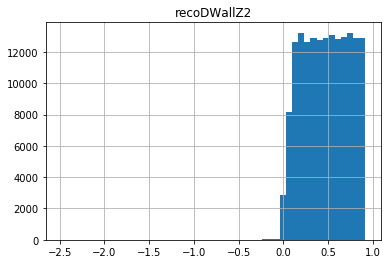

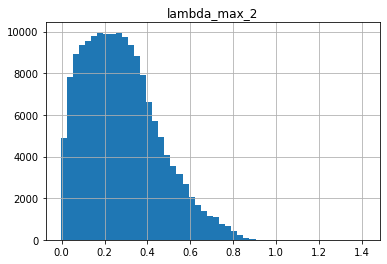

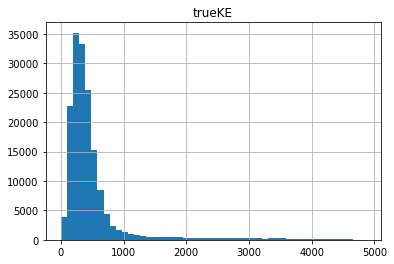

In [45]:
# show 1D distributions of the variables
nbins=50
plotfeatures = features+target
for index, feature in enumerate(plotfeatures):
    hist = data_all.hist(bins=nbins, column=feature)

### Exercise 2

In [46]:
# shuffle dataframe and reset index
from sklearn.utils import shuffle
data_all = shuffle(data_all, random_state=240198)
data_all.reset_index(inplace=True)
data_all.head(5)

index    trueKE  total_hits2  total_ring_PEs2  recoDWallR2  recoDWallZ2  \
0   60067   139.329     0.015625          0.00000     0.218045     0.474414   
1  157458   237.521     0.038575          0.04925     0.407200     0.342547   
2   88052   270.726     0.037850          0.06330     0.514947     0.129228   
3   14097   377.715     0.063175          0.09540     0.627364     0.720368   
4  125215  2207.770     0.489925          0.70200     0.286569     0.803861   

   lambda_max_2  
0      0.399897  
1      0.119460  
2      0.212597  
3      0.224467  
4      0.376045

In [47]:
# shuffle data into training:testing data in 70%:30% split
from sklearn import model_selection
myluckynumber = 7
train_data, test_data, train_target, test_target = model_selection.train_test_split(data_all[features], data_all[target], test_size=0.3, random_state=myluckynumber) 
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(116330, 5) (116330, 1) (49856, 5) (49856, 1)


In [48]:
# create a generalised NN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

####
# A workout around Tensorflow.version = 2.0 for Python 3.x is the need to ensure 'my_model()' takes in no arguments
# Does mean loss of generality when working at home
####
def my_model():
    num_inputs = 5  
    num_nodes = 50
    extra_depth = 5
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer = 'normal', activation='relu'))
    model.add(Dropout(0.2))
    for i in range(extra_depth):
        # code up the extra layers here
        model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss = 'mean_squared_error', optimizer ='adam')
    return model

In [49]:
# implement the model callback 
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_ = [
    # if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
    EarlyStopping(verbose=True, patience=10, monitor ='loss'),
    # Always make sure that we ’re saving the model weights with the best accuracy .
    ModelCheckpoint('model.h5', monitor ='loss', verbose=0, save_best_only=True, mode ='max')]

In [50]:
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# batch size and number of epochs for cross validation
batchSize = 1000
N_epochs = 50
myluckynumber = 7 
np.random.seed(myluckynumber)

# create my model 
#num_inputs = 5
#num_nodes = 10
#extra_depth = 2
#chosen_model = my_model(num_inputs, num_nodes, extra_depth)

# get all data and target, convert to numpy array
cval_data = data_all[features].to_numpy()
cval_target = data_all[target].to_numpy().ravel()

# create pipeline with a single estimator
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=my_model, epochs=N_epochs, batch_size=batchSize, verbose=1))) 
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=myluckynumber, shuffle=True) 
results = cross_val_score(pipeline, cval_data, cval_target, cv=kfold, scoring='r2', fit_params = {'mlp__callbacks': callbacks_})
print('Result: %.2f %s %.2f' % (results.mean(), u'\u00B1', results.std()))

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 5s 31us/sample - loss: 633852.4553
Epoch 2/50
149567/149567 [==============================] - 2s 12us/sample - loss: 631337.0201
Epoch 3/50
149567/149567 [==============================] - 2s 16us/sample - loss: 576467.1819
Epoch 4/50
149567/149567 [==============================] - 2s 14us/sample - loss: 376835.2053
Epoch 5/50
149567/149567 [==============================] - 2s 11us/sample - loss: 311347.3219
Epoch 6/50
149567/149567 [==============================] - 2s 11us/sample - loss: 297026.7690
Epoch 7/50
149567/149567 [==============================] - 2s 11us/sample - loss: 278525.6492
Epoch 8/50
149567/149567 [==============================] - 2s 11us/sample - loss: 254208.9300
Epoch 9/50
149567/149567 [==============================] - 2s 14us/sample - loss: 217574.9073
Epoch 10/50
149567/149567 [==============================] - 2s 11us/sample - loss: 167096.3246
Epoch 11/50
149567/149567

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 3s 22us/sample - loss: 630920.4813
Epoch 2/50
149567/149567 [==============================] - 2s 12us/sample - loss: 628081.3722
Epoch 3/50
149567/149567 [==============================] - 2s 11us/sample - loss: 566384.2812
Epoch 4/50
149567/149567 [==============================] - 2s 11us/sample - loss: 364339.9826
Epoch 5/50
149567/149567 [==============================] - 2s 11us/sample - loss: 308595.7709
Epoch 6/50
149567/149567 [==============================] - 2s 11us/sample - loss: 293795.9489
Epoch 7/50
149567/149567 [==============================] - 2s 11us/sample - loss: 274997.7885
Epoch 8/50
149567/149567 [==============================] - 2s 10us/sample - loss: 249408.4667
Epoch 9/50
149567/149567 [==============================] - 2s 11us/sample - loss: 210231.0720
Epoch 10/50
149567/149567 [==============================] - 2s 10us/sample - loss: 158169.0773
Epoch 11/50
149567/149567

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 3s 20us/sample - loss: 632346.2976
Epoch 2/50
149567/149567 [==============================] - 2s 10us/sample - loss: 629474.4442
Epoch 3/50
149567/149567 [==============================] - 2s 10us/sample - loss: 568646.0812
Epoch 4/50
149567/149567 [==============================] - 2s 10us/sample - loss: 367059.6542
Epoch 5/50
149567/149567 [==============================] - 2s 10us/sample - loss: 308932.8768
Epoch 6/50
149567/149567 [==============================] - 2s 10us/sample - loss: 294637.2099
Epoch 7/50
149567/149567 [==============================] - 2s 10us/sample - loss: 276756.0424
Epoch 8/50
149567/149567 [==============================] - 2s 10us/sample - loss: 250776.5725
Epoch 9/50
149567/149567 [==============================] - 2s 10us/sample - loss: 213325.1028
Epoch 10/50
149567/149567 [==============================] - 2s 10us/sample - loss: 161249.3731
Epoch 11/50
149567/149567

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 3s 20us/sample - loss: 634580.4102
Epoch 2/50
149567/149567 [==============================] - 2s 12us/sample - loss: 631601.1523
Epoch 3/50
149567/149567 [==============================] - -0s -1us/sample - loss: 566678.7773
Epoch 4/50
149567/149567 [==============================] - 2s 10us/sample - loss: 362156.6891
Epoch 5/50
149567/149567 [==============================] - 2s 10us/sample - loss: 309087.3258
Epoch 6/50
149567/149567 [==============================] - 2s 10us/sample - loss: 293918.4734
Epoch 7/50
149567/149567 [==============================] - 2s 10us/sample - loss: 274325.7197
Epoch 8/50
149567/149567 [==============================] - 2s 10us/sample - loss: 245815.5081
Epoch 9/50
149567/149567 [==============================] - 2s 10us/sample - loss: 203231.3257
Epoch 10/50
149567/149567 [==============================] - 2s 10us/sample - loss: 150181.3512
Epoch 11/50
149567/14956

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 3s 20us/sample - loss: 632727.9992
Epoch 2/50
149567/149567 [==============================] - 2s 11us/sample - loss: 630072.6080
Epoch 3/50
149567/149567 [==============================] - 2s 10us/sample - loss: 573842.7816
Epoch 4/50
149567/149567 [==============================] - 2s 11us/sample - loss: 374307.9336
Epoch 5/50
149567/149567 [==============================] - 2s 10us/sample - loss: 310410.9238
Epoch 6/50
149567/149567 [==============================] - 2s 10us/sample - loss: 295798.9543
Epoch 7/50
149567/149567 [==============================] - 2s 10us/sample - loss: 277276.6841
Epoch 8/50
149567/149567 [==============================] - 2s 10us/sample - loss: 252713.5994
Epoch 9/50
149567/149567 [==============================] - 2s 11us/sample - loss: 215938.4366
Epoch 10/50
149567/149567 [==============================] - 2s 11us/sample - loss: 166119.3943
Epoch 11/50
149567/149567

Train on 149567 samples
Epoch 1/50
149567/149567 [==============================] - 3s 21us/sample - loss: 633058.4197
Epoch 2/50
149567/149567 [==============================] - 2s 10us/sample - loss: 630633.2472
Epoch 3/50
149567/149567 [==============================] - 2s 10us/sample - loss: 578088.1700
Epoch 4/50
149567/149567 [==============================] - 2s 10us/sample - loss: 380380.6134
Epoch 5/50
149567/149567 [==============================] - 2s 10us/sample - loss: 310859.0711
Epoch 6/50
149567/149567 [==============================] - 2s 10us/sample - loss: 296515.4920
Epoch 7/50
149567/149567 [==============================] - 2s 10us/sample - loss: 279415.2394
Epoch 8/50
149567/149567 [==============================] - 2s 10us/sample - loss: 255449.4800
Epoch 9/50
149567/149567 [==============================] - 2s 10us/sample - loss: 220372.6627
Epoch 10/50
149567/149567 [==============================] - 2s 10us/sample - loss: 171599.8584
Epoch 11/50
149567/149567

Train on 149568 samples
Epoch 1/50
149568/149568 [==============================] - 3s 19us/sample - loss: 632834.5525
Epoch 2/50
149568/149568 [==============================] - 2s 10us/sample - loss: 630368.6205
Epoch 3/50
149568/149568 [==============================] - 2s 17us/sample - loss: 575064.0351
Epoch 4/50
149568/149568 [==============================] - 2s 11us/sample - loss: 374601.6023
Epoch 5/50
149568/149568 [==============================] - 2s 10us/sample - loss: 310654.2565
Epoch 6/50
149568/149568 [==============================] - 2s 13us/sample - loss: 296477.1771
Epoch 7/50
149568/149568 [==============================] - 2s 11us/sample - loss: 278200.9696
Epoch 8/50
149568/149568 [==============================] - 2s 12us/sample - loss: 254087.6915
Epoch 9/50
149568/149568 [==============================] - 2s 11us/sample - loss: 218562.8121
Epoch 10/50
149568/149568 [==============================] - 2s 12us/sample - loss: 168331.9635
Epoch 11/50
149568/149568

Train on 149568 samples
Epoch 1/50
149568/149568 [==============================] - 3s 20us/sample - loss: 630149.2938
Epoch 2/50
149568/149568 [==============================] - 2s 11us/sample - loss: 627794.6109
Epoch 3/50
149568/149568 [==============================] - 2s 11us/sample - loss: 578783.7750
Epoch 4/50
149568/149568 [==============================] - 2s 11us/sample - loss: 385097.4460
Epoch 5/50
149568/149568 [==============================] - 2s 11us/sample - loss: 310326.3044
Epoch 6/50
149568/149568 [==============================] - 2s 11us/sample - loss: 296008.8890
Epoch 7/50
149568/149568 [==============================] - 2s 11us/sample - loss: 279350.4818
Epoch 8/50
149568/149568 [==============================] - 2s 11us/sample - loss: 255646.9170
Epoch 9/50
149568/149568 [==============================] - 2s 11us/sample - loss: 221090.7760
Epoch 10/50
149568/149568 [==============================] - 2s 11us/sample - loss: 174392.1183
Epoch 11/50
149568/149568

Train on 149568 samples
Epoch 1/50
149568/149568 [==============================] - 3s 20us/sample - loss: 632786.2072
Epoch 2/50
149568/149568 [==============================] - 2s 11us/sample - loss: 629895.6976
Epoch 3/50
149568/149568 [==============================] - 2s 11us/sample - loss: 568529.4336
Epoch 4/50
149568/149568 [==============================] - 2s 11us/sample - loss: 367209.4284
Epoch 5/50
149568/149568 [==============================] - 2s 11us/sample - loss: 310276.0912
Epoch 6/50
149568/149568 [==============================] - 2s 11us/sample - loss: 295860.7037
Epoch 7/50
149568/149568 [==============================] - 2s 11us/sample - loss: 277532.0084
Epoch 8/50
149568/149568 [==============================] - 2s 11us/sample - loss: 252608.5316
Epoch 9/50
149568/149568 [==============================] - 2s 11us/sample - loss: 214514.7683
Epoch 10/50
149568/149568 [==============================] - 2s 11us/sample - loss: 162935.9595
Epoch 11/50
149568/149568

Train on 149568 samples
Epoch 1/50
149568/149568 [==============================] - 3s 19us/sample - loss: 630241.1330
Epoch 2/50
149568/149568 [==============================] - 2s 11us/sample - loss: 627394.0715
Epoch 3/50
149568/149568 [==============================] - 2s 11us/sample - loss: 568181.7320
Epoch 4/50
149568/149568 [==============================] - 2s 11us/sample - loss: 368190.9951
Epoch 5/50
149568/149568 [==============================] - 2s 11us/sample - loss: 309074.7543
Epoch 6/50
149568/149568 [==============================] - 2s 11us/sample - loss: 294849.4037
Epoch 7/50
149568/149568 [==============================] - 2s 10us/sample - loss: 276887.3400
Epoch 8/50
149568/149568 [==============================] - 2s 11us/sample - loss: 252076.9019
Epoch 9/50
149568/149568 [==============================] - 2s 11us/sample - loss: 215193.8126
Epoch 10/50
149568/149568 [==============================] - 2s 11us/sample - loss: 164382.4333
Epoch 11/50
149568/149568

Result: 0.73 ± 0.01


In [51]:
# run the training data on the chosen model with the testing data as validation data
batch_size=1000
nepochs = 50

chosen_model = my_model()
history = chosen_model.fit(train_data, train_target, batch_size=batch_size, epochs=nepochs, verbose=1, validation_data=(test_data, test_target))

Train on 116330 samples, validate on 49856 samples
Epoch 1/50
116330/116330 [==============================] - 3s 22us/sample - loss: 632469.8761 - val_loss: 632082.6460
Epoch 2/50
116330/116330 [==============================] - 1s 12us/sample - loss: 631911.6212 - val_loss: 630260.7819
Epoch 3/50
116330/116330 [==============================] - 1s 12us/sample - loss: 621321.5437 - val_loss: 600445.6244
Epoch 4/50
116330/116330 [==============================] - 1s 12us/sample - loss: 538861.1340 - val_loss: 446282.0438
Epoch 5/50
116330/116330 [==============================] - 1s 12us/sample - loss: 364230.9559 - val_loss: 316296.8690
Epoch 6/50
116330/116330 [==============================] - 1s 12us/sample - loss: 312743.2077 - val_loss: 304479.0309
Epoch 7/50
116330/116330 [==============================] - 1s 12us/sample - loss: 302214.0861 - val_loss: 292931.2615
Epoch 8/50
116330/116330 [==============================] - 1s 12us/sample - loss: 289282.7629 - val_loss: 279275.32

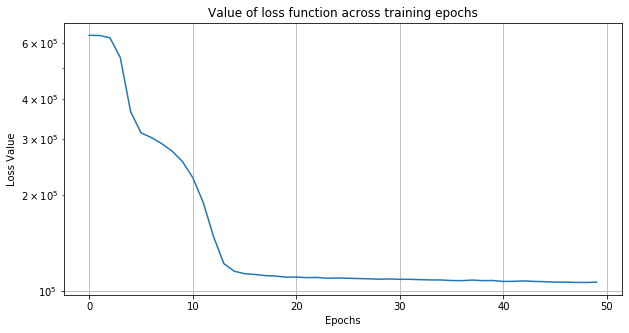

In [52]:
# plot the evolution of the loss function
import nn_utils
loss = history.history['loss']
nn_utils.lossplot(loss, scale='log')

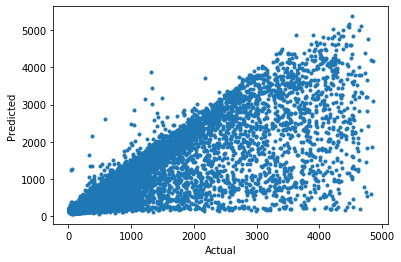

In [53]:
# get predicted muon energies and compare to test_target
predicted = chosen_model.predict(test_data)
plt.scatter(test_target, predicted, marker='.')
plt.xlabel('Actual'), plt.ylabel('Predicted')
plt.show()

### Exercise 3

In [54]:
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV

gbr0 = GradientBoostingRegressor(n_estimators=100) 
gbr0.fit(train_data, train_target.to_numpy().ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
# print the R^2 score for the training and testing data
print(gbr0.score(train_data, train_target))
print(gbr0.score(test_data, test_target))

0.7791110598491029
0.776093927556536


It is clear that the default parameters of GBRT outperforms NN, even when I try to optimise the parameters of NN.

In [ ]:
# conduct optimisation using grid seatch of the Regressor's parameters and cross validation parameters
# we use this to find the optimal regressor
param_grid_ = { 
    'n_estimators':[100], 
    'learning_rate': [0.1, 0.01], 
    'max_depth':[5, 20], 
    'min_samples_leaf':[10,100],
    }

# jobs to run in parallel
njobs_=8 

np.random.seed(myluckynumber)

gbr = GradientBoostingRegressor()
classifier = GridSearchCV(estimator=gbr, cv=kfold, param_grid=param_grid_, n_jobs=njobs_, verbose=1) 
classifier.fit(train_data, train_target.to_numpy().ravel()) 
print('Best estimator:')
print(classifier.best_estimator_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# get function from 'https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py'
# plots the learning curve for the best estimator
import nn_utils
nn_utils.plot_learning_curve(classifier.best_estimator_, 'Learning curve for training data', train_data, train_target.to_numpy().ravel())

In [ ]:
nn_utils.plot_learning_curve(classifier.best_estimator_, 'Learning curve for testing data', test_data, test_target.to_numpy().ravel())

In [ ]:
# run the cross validation score on the best GBRT classifier
gbr1 = GradientBoostingRegressor(classifier.best_estimator_.get_params())
results = cross_val_score(gbr1, cval_data, cval_target, cv=kfold, scoring='r2')
print('Result: %.2f %s %.2f' % (results.mean(), u'\u00B1', results.std()))

In [ ]:
# fit the best estimator to the training data
gbr1.fit(train_data, train_target.to_numpy().ravel())

In [ ]:
# predict the results on the testing dataset
predicted = gbr1.predict(test_data)
plt.scatter(test_target, predicted, marker='.')
plt.xlabel('Actual'), plt.ylabel('Predicted')
plt.show()

In [ ]:
# show which input features have the greatest impact on predictive power
importances = gbr1.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [ ]:
# Plot the feature importances of the GBRT
ranked_features = [features[i] for i in indices] 

plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(train_data.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(train_data.shape[1]), ranked_features)
plt.xlim([-1, train_data.shape[1]])
plt.show()